In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt

from components import *

device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")

In [2]:
BATCH_SIZE = 128
INPUT_SIZE = Generator.INPUT_SIZE
REAL_LABEL, FAKE_LABEL = 1, 0
dataloader = get_data_loader(train=True, batch_size=BATCH_SIZE)

In [3]:
def custom_loss(predictions: torch.Tensor, target: int):
    '''
        An extension of the Binary Cross Entropy

        The first term in the product (log) is basically just the BCE
        
        The second term (pow) creates the balance between difficult and easy samples:

            Easy image -> Small distance between prediction and target
                       -> pow near 0 -> less contribution to the total loss
    
            Difficult image -> huge distance between prediction and target
                            -> pow near 1 -> more contribution to the total loss
        
    '''
    if target == 1:
        loss = -torch.log(predictions) * torch.pow(1 - predictions, 2)
    elif target == 0:
        loss = -torch.log(1 - predictions) * torch.pow(predictions, 2)
    else:
        assert False
    return torch.mean(loss)

In [4]:
netG = Generator().to(device)
netD = Discriminator().to(device)
optimizerD = optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))

criterion = custom_loss

G_losses, D_losses = [], []

In [5]:
def train(num_epochs = 1):
    for epoch in range(num_epochs):
        print('   EPOCH: ', epoch)
        for i, data in enumerate(dataloader, 0):
            # ===========TRAIN_DISCRIMINSTOR============
            netD.zero_grad()
            data_real = data[0].to(device)
            output_real = netD(data_real).view(-1)
            errD_real = criterion(output_real, 1)
            errD_real.backward()
            D_x = output_real.mean().item()

            noise = torch.randn(BATCH_SIZE, INPUT_SIZE, 1, 1, device=device)
            data_fake = netG(noise)
            output_fake = netD(data_fake.detach()).view(-1)
            errD_fake = criterion(output_fake, 0)
            errD_fake.backward()
            D_G_z1 = output_fake.mean().item()

            errD = errD_real + errD_fake
            optimizerD.step()

            # ===============TRAIN_GENERATOR===============
            netG.zero_grad()
            output = netD(data_fake).view(-1)
            errG = criterion(output, 1)

            errG.backward()
            D_G_z2 = output.mean().item()
            optimizerG.step()

            # Output training stats
            if i % 100 == 0:
                print('[%.3d/%d]   Loss_D: %.4f   Loss_G: %.4f   D(x): %.4f   D(G(z)): %.4f / %.4f'
                      % (i, len(dataloader), errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

            G_losses.append(errG.item())
            D_losses.append(errD.item())


## TRAINING PROCESS

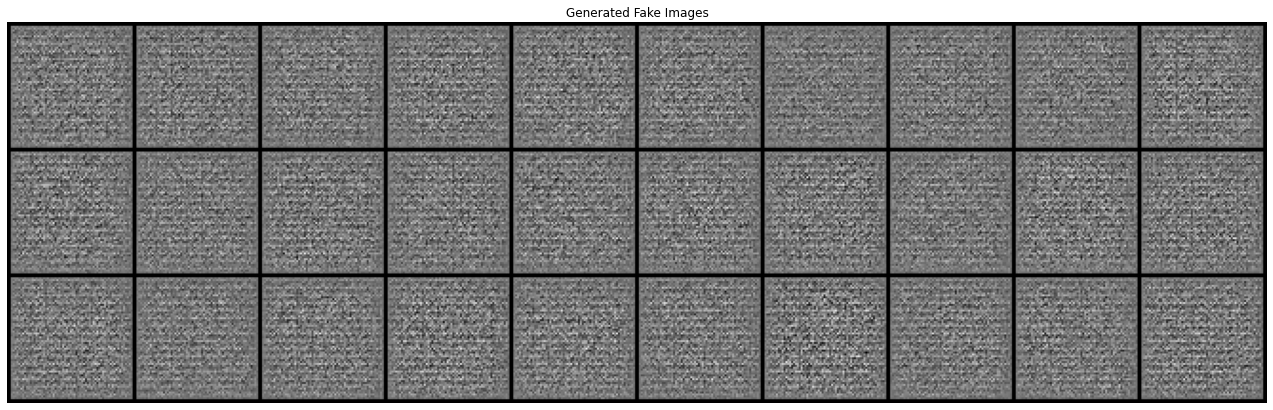

In [6]:
generate_images(netG)

In [7]:
train(num_epochs=10)

   EPOCH:  0
[000/468]   Loss_D: 0.8823   Loss_G: 6.1105   D(x): 0.6164   D(G(z)): 0.6437 / 0.0031
[100/468]   Loss_D: 0.0937   Loss_G: 2.6811   D(x): 0.8366   D(G(z)): 0.2135 / 0.0600
[200/468]   Loss_D: 0.0602   Loss_G: 1.8403   D(x): 0.8711   D(G(z)): 0.2750 / 0.1191
[300/468]   Loss_D: 0.1171   Loss_G: 1.1074   D(x): 0.7762   D(G(z)): 0.3624 / 0.2098
[400/468]   Loss_D: 0.0399   Loss_G: 1.2133   D(x): 0.7751   D(G(z)): 0.2195 / 0.1888
   EPOCH:  1
[000/468]   Loss_D: 0.0322   Loss_G: 1.3689   D(x): 0.8174   D(G(z)): 0.2361 / 0.1592
[100/468]   Loss_D: 0.0363   Loss_G: 1.4648   D(x): 0.8481   D(G(z)): 0.2643 / 0.1493
[200/468]   Loss_D: 0.0240   Loss_G: 1.3932   D(x): 0.8206   D(G(z)): 0.1812 / 0.1601
[300/468]   Loss_D: 0.0484   Loss_G: 2.0552   D(x): 0.8598   D(G(z)): 0.2960 / 0.0909
[400/468]   Loss_D: 0.0259   Loss_G: 1.1805   D(x): 0.8421   D(G(z)): 0.2188 / 0.1907
   EPOCH:  2
[000/468]   Loss_D: 0.1201   Loss_G: 0.5297   D(x): 0.6608   D(G(z)): 0.3085 / 0.3396
[100/468]   Los

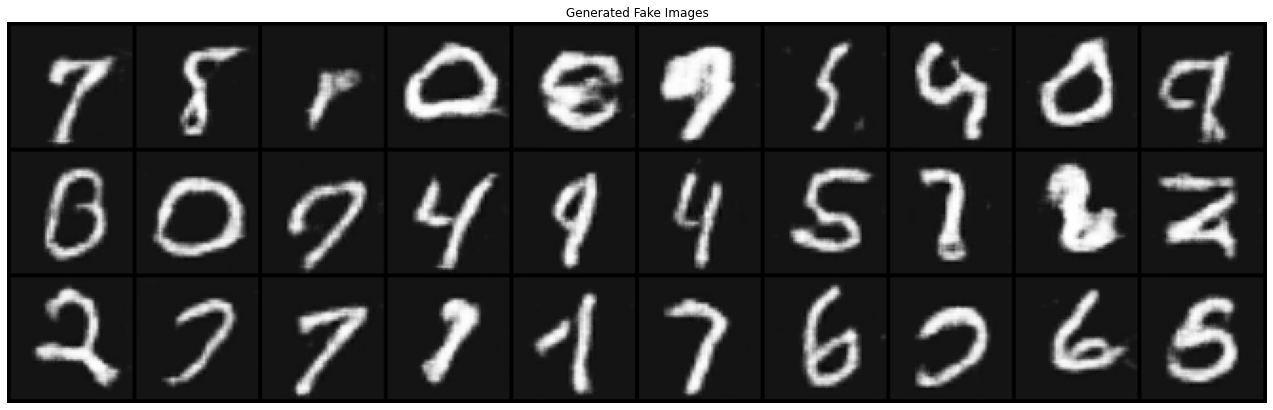

In [8]:
generate_images(netG)

In [9]:
train(num_epochs=10)

   EPOCH:  0
[000/468]   Loss_D: 0.1178   Loss_G: 1.3325   D(x): 0.7543   D(G(z)): 0.3797 / 0.1657
[100/468]   Loss_D: 0.1778   Loss_G: 1.1658   D(x): 0.8305   D(G(z)): 0.4286 / 0.1921
[200/468]   Loss_D: 0.0747   Loss_G: 0.7933   D(x): 0.6643   D(G(z)): 0.1723 / 0.2691
[300/468]   Loss_D: 0.0328   Loss_G: 1.7391   D(x): 0.8463   D(G(z)): 0.2396 / 0.1183
[400/468]   Loss_D: 0.0032   Loss_G: 2.0470   D(x): 0.9082   D(G(z)): 0.0896 / 0.0973
   EPOCH:  1
[000/468]   Loss_D: 0.0040   Loss_G: 2.4842   D(x): 0.8788   D(G(z)): 0.0607 / 0.0677
[100/468]   Loss_D: 0.1557   Loss_G: 1.1755   D(x): 0.6816   D(G(z)): 0.3841 / 0.1900
[200/468]   Loss_D: 0.0670   Loss_G: 1.2486   D(x): 0.7414   D(G(z)): 0.2572 / 0.1800
[300/468]   Loss_D: 0.0247   Loss_G: 2.2200   D(x): 0.8376   D(G(z)): 0.1750 / 0.0908
[400/468]   Loss_D: 0.0190   Loss_G: 2.2752   D(x): 0.9129   D(G(z)): 0.2112 / 0.0793
   EPOCH:  2
[000/468]   Loss_D: 0.0043   Loss_G: 1.9785   D(x): 0.9275   D(G(z)): 0.1283 / 0.0994
[100/468]   Los

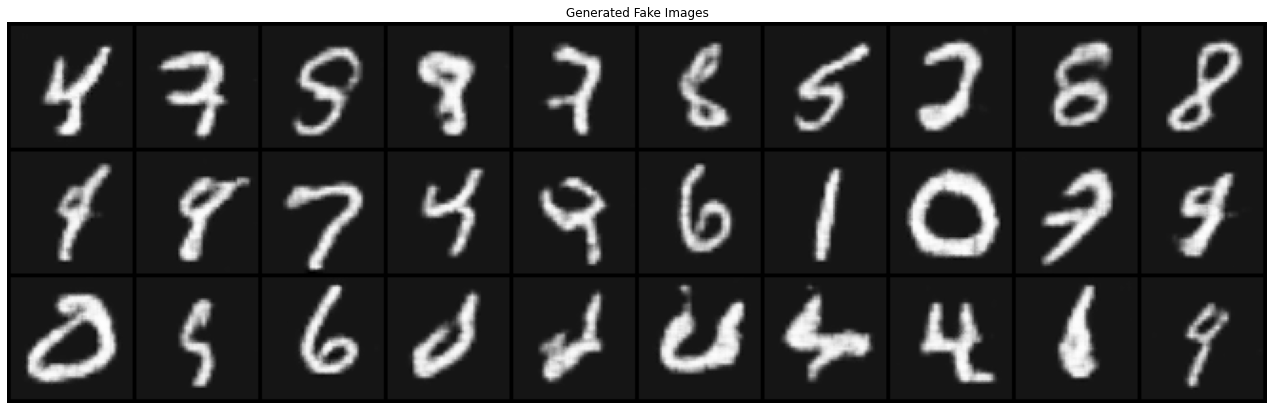

In [10]:
generate_images(netG)

In [11]:
train(num_epochs=10)

   EPOCH:  0
[000/468]   Loss_D: 0.0955   Loss_G: 0.7146   D(x): 0.6860   D(G(z)): 0.2953 / 0.2828
[100/468]   Loss_D: 0.0098   Loss_G: 1.6305   D(x): 0.8689   D(G(z)): 0.1306 / 0.1324
[200/468]   Loss_D: 0.0060   Loss_G: 2.2297   D(x): 0.8591   D(G(z)): 0.0700 / 0.0819
[300/468]   Loss_D: 0.0505   Loss_G: 1.1277   D(x): 0.8060   D(G(z)): 0.2855 / 0.1959
[400/468]   Loss_D: 0.0069   Loss_G: 1.7876   D(x): 0.8721   D(G(z)): 0.1048 / 0.1184
   EPOCH:  1
[000/468]   Loss_D: 5.1259   Loss_G: 1.2886   D(x): 0.0098   D(G(z)): 0.0037 / 0.2486
[100/468]   Loss_D: 0.0823   Loss_G: 0.6209   D(x): 0.6780   D(G(z)): 0.2171 / 0.3174
[200/468]   Loss_D: 0.2259   Loss_G: 0.6019   D(x): 0.6652   D(G(z)): 0.4362 / 0.3150
[300/468]   Loss_D: 0.0824   Loss_G: 0.8655   D(x): 0.7228   D(G(z)): 0.3023 / 0.2486
[400/468]   Loss_D: 0.0245   Loss_G: 1.5568   D(x): 0.7718   D(G(z)): 0.1044 / 0.1401
   EPOCH:  2
[000/468]   Loss_D: 0.0045   Loss_G: 2.1784   D(x): 0.8772   D(G(z)): 0.0730 / 0.0874
[100/468]   Los

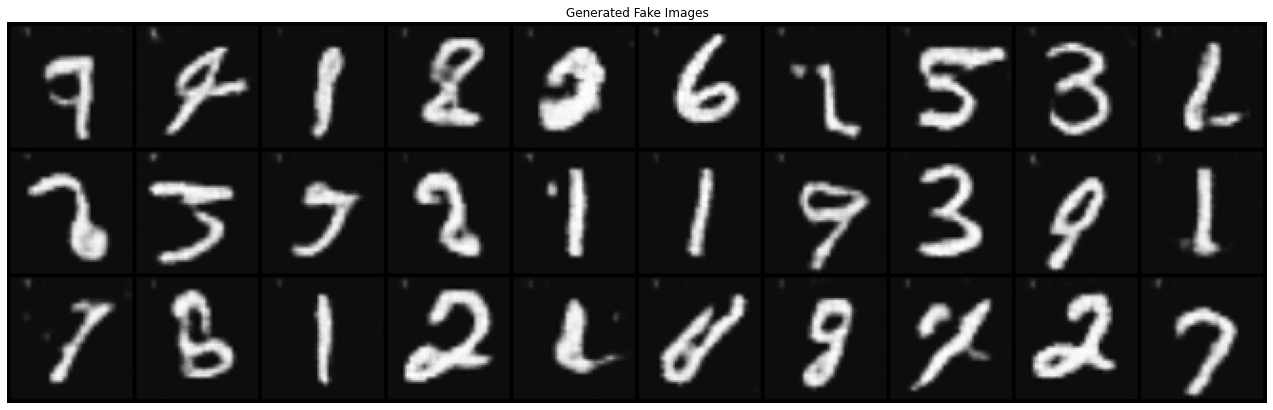

In [12]:
generate_images(netG)

In [13]:
train(num_epochs=10)

   EPOCH:  0
[000/468]   Loss_D: 0.0077   Loss_G: 1.9525   D(x): 0.8532   D(G(z)): 0.0797 / 0.1060
[100/468]   Loss_D: 0.0128   Loss_G: 1.6128   D(x): 0.8567   D(G(z)): 0.1502 / 0.1389
[200/468]   Loss_D: 0.0084   Loss_G: 1.8726   D(x): 0.8981   D(G(z)): 0.1545 / 0.1086
[300/468]   Loss_D: 0.0020   Loss_G: 2.4214   D(x): 0.9101   D(G(z)): 0.0662 / 0.0711
[400/468]   Loss_D: 0.0009   Loss_G: 2.7979   D(x): 0.9313   D(G(z)): 0.0485 / 0.0533
   EPOCH:  1
[000/468]   Loss_D: 0.1766   Loss_G: 0.4933   D(x): 0.5889   D(G(z)): 0.3611 / 0.3462
[100/468]   Loss_D: 0.2662   Loss_G: 0.3161   D(x): 0.4888   D(G(z)): 0.2088 / 0.4456
[200/468]   Loss_D: 0.1034   Loss_G: 0.7022   D(x): 0.6926   D(G(z)): 0.3038 / 0.2904
[300/468]   Loss_D: 0.2311   Loss_G: 0.4410   D(x): 0.5171   D(G(z)): 0.1809 / 0.3913
[400/468]   Loss_D: 0.0110   Loss_G: 1.5016   D(x): 0.8560   D(G(z)): 0.1332 / 0.1496
   EPOCH:  2
[000/468]   Loss_D: 0.0026   Loss_G: 2.0648   D(x): 0.9355   D(G(z)): 0.1045 / 0.0926
[100/468]   Los

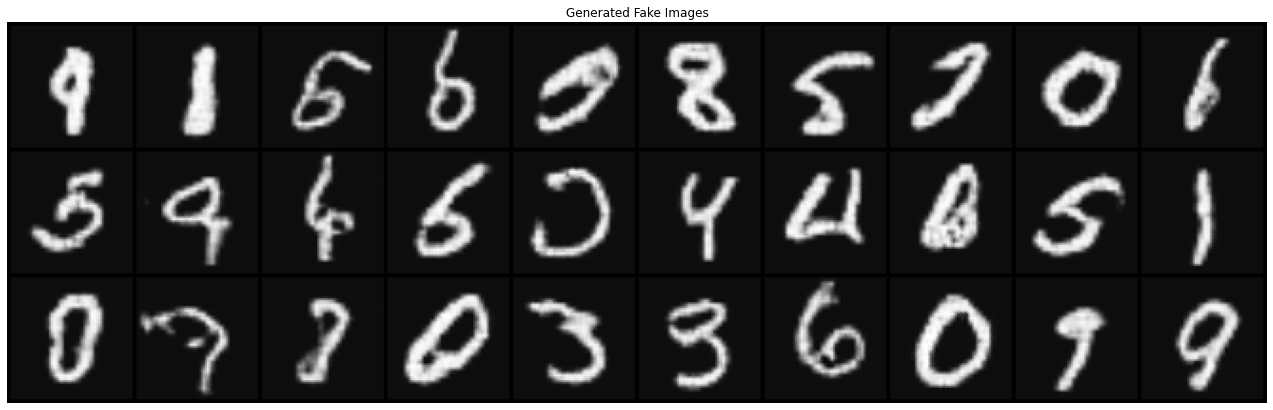

In [14]:
generate_images(netG)

In [15]:
train(num_epochs=10)

   EPOCH:  0
[000/468]   Loss_D: 0.0030   Loss_G: 2.2363   D(x): 0.8891   D(G(z)): 0.0633 / 0.0814
[100/468]   Loss_D: 0.3628   Loss_G: 0.1701   D(x): 0.5144   D(G(z)): 0.3953 / 0.5493
[200/468]   Loss_D: 0.0954   Loss_G: 1.2248   D(x): 0.8065   D(G(z)): 0.3647 / 0.1800
[300/468]   Loss_D: 0.0502   Loss_G: 1.4862   D(x): 0.8022   D(G(z)): 0.2698 / 0.1473
[400/468]   Loss_D: 0.0170   Loss_G: 1.5094   D(x): 0.7977   D(G(z)): 0.1153 / 0.1522
   EPOCH:  1
[000/468]   Loss_D: 0.0086   Loss_G: 1.7930   D(x): 0.9037   D(G(z)): 0.1605 / 0.1146
[100/468]   Loss_D: 0.1421   Loss_G: 0.4667   D(x): 0.6104   D(G(z)): 0.3042 / 0.3625
[200/468]   Loss_D: 0.0767   Loss_G: 1.2024   D(x): 0.7840   D(G(z)): 0.3096 / 0.1872
[300/468]   Loss_D: 0.0075   Loss_G: 1.5847   D(x): 0.8738   D(G(z)): 0.1304 / 0.1395
[400/468]   Loss_D: 0.0026   Loss_G: 2.2134   D(x): 0.9030   D(G(z)): 0.0858 / 0.0818
   EPOCH:  2
[000/468]   Loss_D: 0.1803   Loss_G: 0.4100   D(x): 0.6185   D(G(z)): 0.3893 / 0.3782
[100/468]   Los

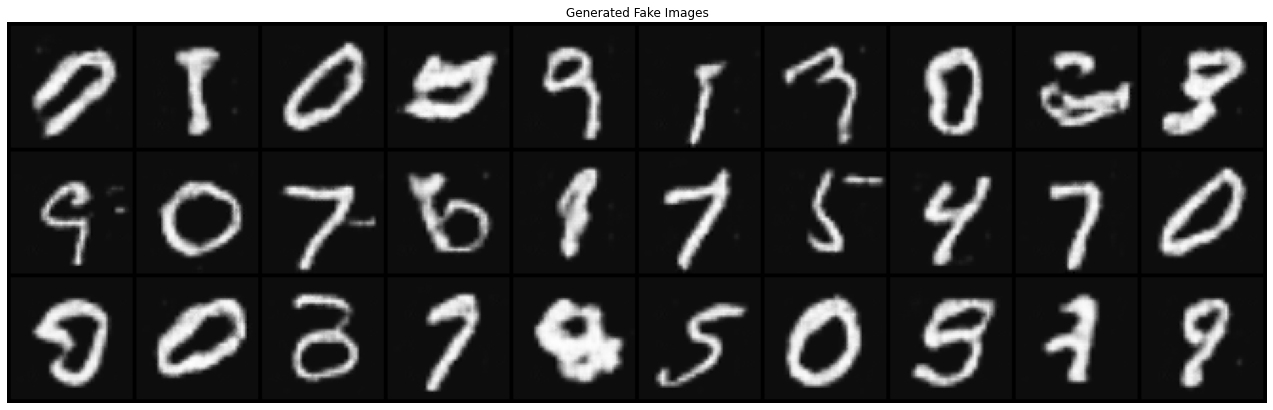

In [16]:
generate_images(netG)

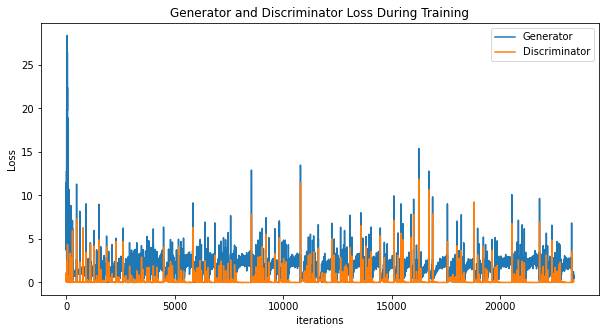

In [17]:
plot_losses(G_losses, D_losses)